<a href="https://colab.research.google.com/github/AbhiMalappa/NLP/blob/main/RAG_deepseek_chromadb_custom_hf_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

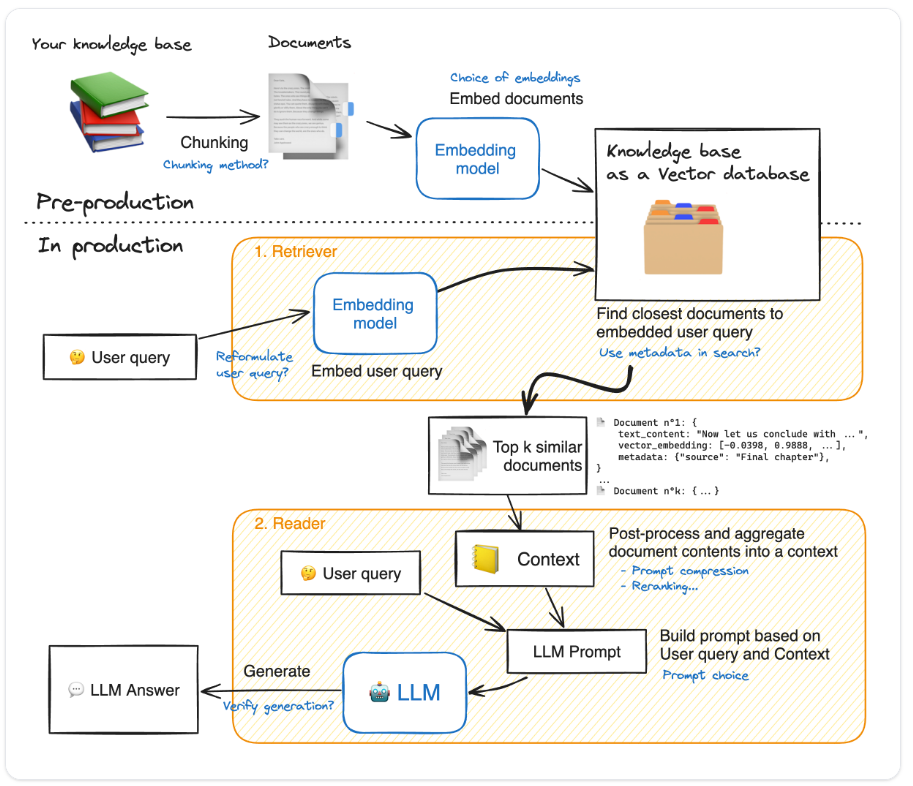

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

!pip install langchain_community -q
!pip install chromadb -q
!pip install tiktoken -q # for chromadb
!pip install langchain_chroma -q
!pip install langchain_huggingface -q

In [ ]:
!pip install bitsandbytes -q ##### restart kernal after this. Runtime restart. Otherwise Quantization step will cry #####
!pip install accelerate -q

### **Create VectorStore db (Chromadb) through custom embedding using HuggingFace sentence transformer model**

##### **langchain doc from dataframe**

In [ ]:
import pandas as pd
# Load your DataFrame
#df = pd.read_csv("drive/MyDrive/Colab Notebooks/NLP/split.csv")
df = pd.read_csv("drive/MyDrive/Colab Notebooks/datastore/training_text_calssifiaction.csv")

df["cluster"] = "Clus1"
df.reset_index(inplace=True)
df.rename(columns={"index": "id"}, inplace=True)
df.head(1)

,id,string_value,Category,cluster
0,0,quick response and resolution of my issue,Others,Clus1


In [ ]:
#HF ticketing system example
import pandas as pd
df = pd.read_csv("hf://datasets/bendubb26/your_support_tickets/your_support_tickets.csv")
df["cluster"] = "Clus1"
df["string_value"] = df["support_tick_id"] + " " + df["support_ticket_text"]
df.reset_index(inplace=True)
df.rename(columns={"index": "id"}, inplace=True)
df['cluster'] = df['cluster'].where(df['id'] <= 3, "Clus2")
df.head(2)
print(f"df shape {df.shape}")

,id,support_tick_id,support_ticket_text,cluster,string_value
0,0,ST2023-006,My internet connection has significantly slowe...,Clus1,ST2023-006 My internet connection has signific...
1,1,ST2023-007,Urgent help required! My laptop refuses to sta...,Clus1,ST2023-007 Urgent help required! My laptop ref...


df shape (21, 5)


In [ ]:
#Create doc from df

#Method1 - easy but no control over metadata.. cant pass it as a parameter, as of now.. if DataFrameLoader module support in future, switch to this
from langchain.document_loaders import DataFrameLoader
loader = DataFrameLoader(df, page_content_column="string_value")
docs = loader.load()

#Method2 - from langchain.schema
from langchain.schema import Document
docs = [Document(
                  page_content=df_row['string_value'],
                  metadata={
                      "id": df_row['id'],
                      "support_tick_id": df_row['support_tick_id'],
                      "cluster": df_row['cluster']
                      }
                  ) for df_idx, df_row in df.iterrows()
        ]

ModuleNotFoundError: Module langchain_community.document_loaders not found. Please install langchain-community to access this module. You can install it using `pip install -U langchain-community`

In [ ]:
type(docs[1])

##### **Custom embedding from HF model**

In [ ]:
# source langchain website - https://python.langchain.com/docs/integrations/text_embedding/sentence_transformers/

from langchain_huggingface import HuggingFaceEmbeddings
# to use have sentence_transformers
hf_embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

text = "This is a test document."
query_result = hf_embeddings.embed_query(text)

# show only the first 100 characters of the stringified vector
print(str(query_result)[:100] + "...")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[-0.0383385568857193, 0.12346474081277847, -0.02864294871687889, 0.053652726113796234, 0.00884537771...


##### **Create Vectorstore**

In [ ]:
!rm -r "chromadb_at_my_location" # remove dir if already creaeted

In [ ]:
# create database
from langchain_chroma import Chroma

db = Chroma.from_documents(   # from_documents when creating it for the first time
    docs, # docs input is required for from_documents
    ids = df['id'].astype(str).to_list(), # need to be string
    collection_name = "ab_collection",
    embedding=hf_embeddings,
    persist_directory="chromadb_at_my_location" # dir where SQLLite chromadb is created
)

In [ ]:
db

In [ ]:
#sample search
results = db.similarity_search_with_score("drive issue", k=2)
results
#low score indicates closer match

[(Document(id='cb319efe-804d-46ba-b013-09a2afcb9881', metadata={'cluster': 'Clus1', 'id': 18, 'support_tick_id': 'ST2023-024', 'support_ticket_text': "My external hard drive isn't being recognized, and I need assistance recovering vital data."}, page_content="ST2023-024 My external hard drive isn't being recognized, and I need assistance recovering vital data."),
  1.149545302578893),
 (Document(id='702f31d4-8a47-4c71-9830-383d4fd11fda', metadata={'cluster': 'Clus1', 'id': 8, 'support_tick_id': 'ST2023-014', 'support_ticket_text': "My external hard drive isn't being recognized by my computer. I need assistance recovering vital data stored on it."}, page_content="ST2023-014 My external hard drive isn't being recognized by my computer. I need assistance recovering vital data stored on it."),
  1.1646807747593568)]

In [ ]:
#Query Chroma DB
db.get(limit=2, where={"cluster": "Clus1"})

# number of docs, with a filter on metadata
ab = db.get(where={"cluster": "Clus1"})
len(ab["documents"])

In [ ]:
# add data to exisitng vectorestore
existing_ids = db.get()["ids"]  # is a list
new_docs=[]
new_docs_ids = []
for item in docs:
  id_to_check = item.metadata["id"]
  try:
    id_to_check = str(id_to_check)
  except:
    pass
  if id_to_check not in existing_ids:
    #print(id_to_check)
    new_docs.append(item)
    new_docs_ids.append(id_to_check)

try:
  db.add_documents(
      documents = new_docs, # docs input is required for from_documents
      ids = new_docs_ids, # need to be string
      collection_name = "ab_collection",
      embedding=hf_embeddings,
      persist_directory="chromadb_at_my_location" # dir where SQLLite chromadb is created
      )
except Exception as e:
  print(e)

**--------------------------------------------------------------------------------------------------------------------------------------------------------------**-

### **Langchain wrapper for HugginFace pipeline**

In [ ]:
#from transformers import pipeline
#huggingface_pipeline = pipeline("text2text-generation", model="facebook/bart-base",max_new_tokens= 500) # max_length=500
# langchain wrapper on hugging face pipeline
#llm = HuggingFacePipeline(pipeline=huggingface_pipeline)

Device set to use cuda:0


##### **Model**

In [ ]:
#model_id = "gpt2"
#model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"
#model_id = "meta-llama/Llama-3.3-70B-Instruct" need access
#model_id = "deepseek-ai/DeepSeek-R1"
model_id = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

##### **Tokenizer instance**

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.save_pretrained('drive/MyDrive/Colab Notebooks/datastore/deepseek/deepseek_tokenizer')

tokenizer_config.json:   0%|          | 0.00/3.06k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

('drive/MyDrive/Colab Notebooks/datastore/deepseek/deepseek_tokenizer/tokenizer_config.json',
 'drive/MyDrive/Colab Notebooks/datastore/deepseek/deepseek_tokenizer/special_tokens_map.json',
 'drive/MyDrive/Colab Notebooks/datastore/deepseek/deepseek_tokenizer/tokenizer.json')

##### **Quantization**

In [ ]:
# Since deepseekR1 is huge, i was not able to bring it into memory. Converting 16 bit precission to 4 bit
#!pip install bitsandbytes -q
#!pip install accelerate -q

from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Or load_in_8bit=True depending on model quantization
    #bnb_4bit_quant_type="nf4",  # Adjust if needed
    #bnb_4bit_use_double_quant=True,  # Adjust if needed
)

##### **Model instance**

In [ ]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    #low_cpu_mem_usage=True # was not working as intended. Mem usage didnt reduce
    quantization_config=quantization_config,
    )
model.save_pretrained('drive/MyDrive/Colab Notebooks/datastore/deepseek/deepseek_model')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.67G [00:00<?, ?B/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/7.39G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [ ]:
#model size details with quantization
print(f"model memory usage in GB {model.get_memory_footprint() / 1e9}")
print(f"model parameter count {model.num_parameters()/1e9} B")

model memory usage in GB 5.59154816
model parameter count 8.030261248 B


In [ ]:
#### without quantization #####
#print(f"model memory usage in GB {model.get_memory_footprint() / 1e9}")
#print(f"model parameter count {model.num_parameters()/1e9} B")

model memory usage in GB 32.12105344
model parameter count 8.030261248 B


##### **Load From previously created model**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained('drive/MyDrive/Colab Notebooks/datastore/deepseek/deepseek_model')
tokenizer = AutoTokenizer.from_pretrained('drive/MyDrive/Colab Notebooks/datastore/deepseek/deepseek_tokenizer')

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

##### **HF pipeline and wrapper for Langchain**

In [ ]:
from langchain_huggingface import HuggingFacePipeline
#documentation https://python.langchain.com/api_reference/huggingface/llms/langchain_huggingface.llms.huggingface_pipeline.HuggingFacePipeline.html#langchain_huggingface.llms.huggingface_pipeline.HuggingFacePipeline

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

ModuleNotFoundError: No module named 'langchain_huggingface'

In [ ]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=500)
llm = HuggingFacePipeline(pipeline=pipe)

Device set to use cuda:0


**--------------------------------------------------------------------------------------------------------------------------------------------------------------**-

### **Create Chatbot**

##### **Langchain retriver**

In [ ]:
from langchain.chains import RetrievalQA
# Define the metadata filter
#metadata_filter = {"Category": "agent_unprofessional"}
metadata_filter = {"cluster": "Clus1"}

# Retrieve documents with the metadata filter applied
retriever = db.as_retriever(search_type="similarity", search_kwargs={"filter": metadata_filter, "k":1})

##### **Conversation Chain**

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
chain = ConversationalRetrievalChain.from_llm(
  llm=llm,
  #llm=ChatOpenAI(openai_api_key=api_key, model="gpt-3.5-turbo"),
  retriever=retriever,
)

In [ ]:
chat_history = []

In [ ]:
query = " hard drive issues "
result = chain({"question": query, "chat_history": chat_history})
result['answer']
chat_history.append((query, result['answer']))

<ipython-input-25-530638714b48>:2: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = chain({"question": query, "chat_history": chat_history})
/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


"Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nST2023-024 My external hard drive isn't being recognized, and I need assistance recovering vital data.\n\nQuestion:  hard drive issues \nHelpful Answer: If your external hard drive isn't recognized, first, check the cable connections. If the drive is still not recognized, try reformatting the drive. If that doesn't work, the drive might be faulty and professional data recovery may be needed.\n---\n\nOkay, so I need to help someone who's having trouble with their external hard drive not being recognized. They mentioned that they need assistance recovering vital data. Let me think through what could be going wrong and what steps they should take.\n\nFirst off, the user might have a hardware issue. Maybe the cable connections are faulty. I remember that sometimes when you connect an external drive, the cable can get loose or

In [ ]:
result['answer']

"Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nST2023-024 My external hard drive isn't being recognized, and I need assistance recovering vital data.\n\nQuestion:  hard drive issues \nHelpful Answer: If your external hard drive isn't recognized, first, check the cable connections. If the drive is still not recognized, try reformatting the drive. If that doesn't work, the drive might be faulty and professional data recovery may be needed.\n---\n\nOkay, so I need to help someone who's having trouble with their external hard drive not being recognized. They mentioned that they need assistance recovering vital data. Let me think through what could be going wrong and what steps they should take.\n\nFirst off, the user might have a hardware issue. Maybe the cable connections are faulty. I remember that sometimes when you connect an external drive, the cable can get loose or